In [0]:
#Importo Librerias
import pandas as pd
import os 
import numpy as np

!pip install geopandas
import geopandas as gpd
from shapely.geometry import Point
from shapely import wkt
from shapely.ops import split, snap


!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import drive

!pip install -U pandasql

import pandasql as pdsql

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm

!pip install folium

import folium

from folium import plugins
from folium.plugins import HeatMap

import math

     |████████████████████████████████| 901kB 2.8MB/s 
     |████████████████████████████████| 11.2MB 38.2MB/s 
     |████████████████████████████████| 17.9MB 31.6MB/s 
  Stored in directory: /root/.cache/pip/wheels/db/bf/bc/06a3e1bfe0ab27d2e720ceb3cff3159398d92644c0cec2c125
Successfully built munch
     |████████████████████████████████| 993kB 2.9MB/s 
  Stored in directory: /root/.cache/pip/wheels/53/6c/18/b87a2e5fa8a82e9c026311de56210b8d1c01846e18a9607fc9
Successfully built pandasql


In [0]:
##Me autentifico con google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#Monto el drive
#drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
##Creo directorio donde se descomprimirán los archivos
download_path = os.path.expanduser('~/data')
try:
  os.makedirs(download_path)
except FileExistsError:
  pass

In [0]:
##Listo los archivos con extensión xlsx
#listed = drive.ListFile().GetList()
#for file in [x for x in listed if x['title'][-4:]=='xlsx'][:6]:
#  print('title {}, id {}'.format(file['title'], file['id']))

title L33_20190424_recorrido_T.xlsx, id 1tH-Xk8_Gjuu-FXbqNsmEXcvGJgJLwE7W
title L33_20190424.xlsx, id 0B-HO31H0CNLaLVJwbUY5TnJLdXVUNVNDZUJlTUQwMFdMSVV3
title export_dataframe.xlsx, id 1_BqOdVe1JuKxlhtwWGS4M0KQZeqkySms
title Porto Real. Depósitos . Gastos 2019.xlsx, id 1rkHyK0DxajKPEDd2IdLQatlpLYtH9yYn
title Targets_videos_viejos.xlsx, id 1yOc3mTAbNKVqMZV6MrGvRJEXiP-q3RxP
title Targets_videos_nuevos.xlsx, id 14pZWjKGO5mFSrhgi4P7XaSZlml_zBEAp


In [0]:
targets_viejos = os.path.join(download_path, 'Targets_videos_viejos.xlsx')
temp_file = drive.CreateFile({'id': '1yOc3mTAbNKVqMZV6MrGvRJEXiP-q3RxP'})
temp_file.GetContentFile(targets_viejos)

recorrido_t = os.path.join(download_path, 'L33_20190424_recorrido_T.xlsx')
temp_file = drive.CreateFile({'id': '1tH-Xk8_Gjuu-FXbqNsmEXcvGJgJLwE7W'})
temp_file.GetContentFile(recorrido_t)

In [0]:
#Importo las distintas hojas
targets = pd.read_excel(targets_viejos, sheet_name='videos')
trx_eco = pd.read_excel(targets_viejos, sheet_name='TRX_ECO')
avl = pd.read_excel(targets_viejos, sheet_name='AVL')
rec_teoricos = pd.read_excel(recorrido_t, sheet_name='Recorridos teoricos')

In [0]:
##Miro si cargaron bien las fechas y los demas campos
print('Targets')
print('-------------------------')
print(targets.info())
print('Transacciones económicas')
print('-------------------------')
print(trx_eco.info())
print('Transacciones AVL (Automatic Vehicle Location)')
print('-------------------------')
print(avl.info())
print('-------------------------')
print(rec_teoricos.info())

In [0]:
##Me aseguro que este ordenado
avl = avl.sort_values(['INTERNO','RECORD_DATE', 'DTSN'])
trx_eco = trx_eco.sort_values(['INTERNO','FECHATRX', 'CODIGOTRXTERMINAL'])

##Agrego la fecha siguiente a la transaccion en el archivo de avl y en el de trx eco
avl['RECORD_DATE_POST'] = avl.groupby(['INTERNO'])['RECORD_DATE'].shift(-1)
trx_eco['FECHATRX_POST'] = trx_eco.groupby(['INTERNO'])['FECHATRX'].shift(-1)

In [0]:
##Genero una tabla que me permitirá filtrar las fechas y horas de los videos de cada uno de los internos
fechas = targets.groupby(['INTERNO']).agg({'Fecha_hora' : [np.min, np.max]}).reset_index()
fechas.columns = list(map(''.join, fechas.columns.values))

In [0]:
##Joineo con la tabla target y la tabla fechas
q = """SELECT A.ID, A.ENTIDAD, A.LINEA, A.RAMAL, A.RECORD_DATE, A.DTSN, A.INTERNO,
              A.DISTANCE, A.SPEED, A.TYPE, A.LONGITUDE, A.LATITUDE, A.UTILIZED_SATELLITES, A.RECORD_DATE_POST, 
              max(B.cantidad) as MAX_CANTIDAD, 
              min(B.cantidad) as MIN_CANTIDAD, 
              sum(B.bajaron) as BAJARON, 
              sum(B.subieron) as SUBIERON, 
              count(*) CANT_IMG_VIDEOS
       FROM avl A
        left join targets B
          on A.INTERNO = B.INTERNO
          and B.Fecha_hora >= A.RECORD_DATE
          and B.Fecha_hora < A.RECORD_DATE_POST
         join fechas C
           on A.INTERNO = C.INTERNO
           and A.RECORD_DATE >= C.Fecha_horaamin
           and A.RECORD_DATE <= C.Fecha_horaamax
       GROUP BY A.ID, A.ENTIDAD, A.LINEA, A.RAMAL, A.RECORD_DATE, A.DTSN, A.INTERNO,
                A.DISTANCE, A.SPEED, A.TYPE, A.LONGITUDE, A.LATITUDE, A.UTILIZED_SATELLITES, A.RECORD_DATE_POST
       ORDER BY A.INTERNO, A.RECORD_DATE, A.RECORD_DATE_POST"""
new_dataframe = pdsql.sqldf(q, locals())

In [0]:
##Agrego el campo entidad
new_dataframe['CANTIDAD'] = np.where((new_dataframe['SUBIERON'] - new_dataframe['BAJARON']) >= 0, 
                                     new_dataframe['MAX_CANTIDAD'], 
                                     new_dataframe['MIN_CANTIDAD'])

new_dataframe['CANTIDAD'] = np.where((new_dataframe['SUBIERON'] - new_dataframe['BAJARON']) == 0, 
                                     new_dataframe['MAX_CANTIDAD'], 
                                     new_dataframe['CANTIDAD'].shift(1)+(new_dataframe['SUBIERON'] - new_dataframe['BAJARON']))

In [0]:
new_dataframe.groupby('INTERNO')['INTERNO'].count()

INTERNO
4001    40
4032    41
4049    40
Name: INTERNO, dtype: int64

In [0]:
##Agrupo por lat y long para eliminar los puntos exactos
q = """SELECT ENTIDAD,LINEA,RAMAL, INTERNO, LONGITUDE, LATITUDE,  
              min(RECORD_DATE) RECORD_DATE,
              min(ID) ID,
              max(CANTIDAD) as MAX_CANTIDAD, 
              min(CANTIDAD) as MIN_CANTIDAD, 
              sum(BAJARON) as BAJARON, 
              sum(SUBIERON) as SUBIERON
       FROM new_dataframe
       GROUP BY ENTIDAD, LINEA, RAMAL, INTERNO, LONGITUDE, LATITUDE
       ORDER BY 4, 7"""
puntos_corte = pdsql.sqldf(q, locals())

In [0]:
##Agrego el campo entidad
puntos_corte['CANTIDAD'] = np.where((puntos_corte['SUBIERON'] - puntos_corte['BAJARON']) >= 0, 
                                     puntos_corte['MAX_CANTIDAD'], 
                                     puntos_corte['MIN_CANTIDAD'])

puntos_corte['CANTIDAD'] = np.where((puntos_corte['SUBIERON'] - puntos_corte['BAJARON']) == 0, 
                                     puntos_corte['MAX_CANTIDAD'], 
                                     puntos_corte['CANTIDAD'].shift(1)+(puntos_corte['SUBIERON'] - puntos_corte['BAJARON']))

In [0]:
#path arrays
#arrays_path = './gdrive/My Drive/'

## guardo el data frame en el disco para controlarlo en excel
#new_dataframe.to_excel (arrays_path + 'export_dataframe.xlsx', index = None, header=True) #Don't forget to add '.xlsx' at the end of the path


In [0]:
## Defino el esquema de color con el cual voy a trabajar
def color_grosor (data, field, n):
  limites = list(np.linspace(data[field].min()-1, data[field].max() + 1, n+1))
  
  cmap = cm.get_cmap('plasma', n+1) #gnuplot, Reds
  color = []
  for i in range(cmap.N):
      rgb = cmap(i)[:3]
      color.append(mpl.colors.rgb2hex(rgb))
  
  df = pd.DataFrame(list(zip(limites, color)), columns =['limite_inf', 'color'])
  df['limite_sup']=df.limite_inf.shift(-1)
  
  df = df.loc[np.isnan(df.limite_sup)!= True]
  
  df['grosor'] = df.index +1
  
  return df


color = color_grosor(puntos_corte, 'CANTIDAD', 10)

In [0]:
##Le pego el color a los dos data frame
q = """SELECT A.*, B.color, b.grosor
       FROM puntos_corte A
        left join color B
          on A.CANTIDAD > B.limite_inf
          and A.CANTIDAD <= B.limite_sup"""
puntos_corte = pdsql.sqldf(q, locals())

q = """SELECT A.*, B.color, b.grosor
       FROM new_dataframe A
        left join color B
          on A.CANTIDAD > B.limite_inf
          and A.CANTIDAD <= B.limite_sup"""
new_dataframe = pdsql.sqldf(q, locals())

In [0]:
##Convierto en geopandas
#Transformo la long y lat en geometry
geometry = [Point(xy) for xy in zip(new_dataframe.LONGITUDE, new_dataframe.LATITUDE)]
# convierto a geodataframe
new_dataframe = gpd.GeoDataFrame(new_dataframe, geometry=geometry, crs={'init' :'epsg:4326'})


##creo el campo geometry
rec_teoricos['GEOMETRY'] = rec_teoricos['GEOMETRY'].apply(wkt.loads)
#Convierto en geodata frame
rec_teoricos = gpd.GeoDataFrame(rec_teoricos, geometry='GEOMETRY',crs={'init' :'epsg:4326'})


#Transformo la long y lat en geometry
geometry = [Point(xy) for xy in zip(puntos_corte.LONGITUDE, puntos_corte.LATITUDE)]
# convierto a geodataframe
puntos_corte = gpd.GeoDataFrame(puntos_corte, geometry=geometry, crs={'init' :'epsg:4326'})



In [0]:
#Filtro LONG 0 
new_dataframe = new_dataframe.loc[(new_dataframe.LONGITUDE != 0)].reset_index()
puntos_corte = puntos_corte.loc[(puntos_corte.LONGITUDE != 0)].reset_index()

In [0]:
#############################
###### Líneas teórica #######
#############################
m = folium.Map(location=[-34.6, -58.4], 
               zoom_start=12, 
               tiles = 'cartodbdark_matter')


### RAMAL A IDA
A_ida = folium.FeatureGroup(name='L150 A IDA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'IDA') & (rec_teoricos.RECORRIDO == 'A')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#FF0000', opacity=0.9).add_to(A_ida)

#Creo la flecha para indicar sentido
attr = {'fill': '#FFFFFF', 'opacity' : 0.7, 'font-size': 8}

plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset=2,
                         attributes=attr).add_to(A_ida)
A_ida.add_to(m)

### RAMAL A VUELTA
A_vuelta = folium.FeatureGroup(name='L150 A VUELTA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'VUELTA') & (rec_teoricos.RECORRIDO == 'A')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#FF6868', opacity=0.9).add_to(A_vuelta)

#Creo la flecha para indicar sentido
attr = {'fill': '#FF0000', 'opacity' : 0.9, 'font-size': 8}

plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset = 2,
                         attributes=attr).add_to(A_vuelta)
A_vuelta.add_to(m)


### RAMAL B IDA
B_ida = folium.FeatureGroup(name='L150 B IDA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'IDA') & (rec_teoricos.RECORRIDO == 'B')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#0074FF', opacity=0.9).add_to(B_ida)

#Creo la flecha para indicar sentido
attr = {'fill': '#FFFFFF', 'opacity' : 0.7, 'font-size': 8}

plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset=2,
                         attributes=attr).add_to(B_ida)
B_ida.add_to(m)

### RAMAL B VUELTA
B_vuelta = folium.FeatureGroup(name='L150 B VUELTA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'VUELTA') & (rec_teoricos.RECORRIDO == 'B')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#7CB7FF', opacity=0.9).add_to(B_vuelta)

#Creo la flecha para indicar sentido
attr = {'fill': '#0074FF', 'opacity' : 0.9, 'font-size': 8}

plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset = 2,
                         attributes=attr).add_to(B_vuelta)
B_vuelta.add_to(m)


folium.TileLayer('cartodbdark_matter').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)


# add the layer control
folium.LayerControl().add_to(m)

m

In [0]:
###########################
### Gráfico de Burbujas ###
###########################
### Mapa de fondo ###
m = folium.Map(location= list(new_dataframe[['LATITUDE', 'LONGITUDE']].mean()), ##[-34.625, -58.4], 
               zoom_start=12.4,
               tiles = 'cartodbdark_matter')

### Línea teórica ###
### RAMAL B VUELTA
B_vuelta = folium.FeatureGroup(name='L150 B VUELTA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'VUELTA') & (rec_teoricos.RECORRIDO == 'B')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#7CB7FF', opacity=0.4).add_to(B_vuelta)

#Creo la flecha para indicar sentido
attr = {'fill': '#000000', 'opacity' : 0.9, 'font-size': 8}

plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset = 2,
                         attributes=attr).add_to(B_vuelta)
B_vuelta.add_to(m)

### Creo las burbujas ###
int4001 = folium.FeatureGroup(name='Interno 4001')
[folium.Circle(location=[row['geometry'].y, row['geometry'].x], 
               radius = row['grosor']*row['CANTIDAD']/1.5,
               popup = 'FECHA: ' + str(row['RECORD_DATE']) +'\r'+'CANTIDAD: ' + str(row['CANTIDAD']),
               color= row['color'],
               fill=True,
               fill_color='crimson').add_to(int4001) for index, row in  new_dataframe.iterrows() if row['INTERNO'] == 4001]

int4032 = folium.FeatureGroup(name='Interno 4032')
[folium.Circle(location=[row['geometry'].y, row['geometry'].x], 
               radius = row['grosor']*row['CANTIDAD']/1.5,
               popup = 'FECHA: ' + str(row['RECORD_DATE']) +'\r'+'CANTIDAD: ' + str(row['CANTIDAD']),
               color=row['color'],
               fill=True,
               fill_color='#81D3FF').add_to(int4032) for index, row in  new_dataframe.iterrows() if row['INTERNO'] == 4032]

int4049 = folium.FeatureGroup(name='Interno 4049')
[folium.Circle(location=[row['geometry'].y, row['geometry'].x], 
               radius = row['grosor']*row['CANTIDAD']/1.5,
               popup = 'FECHA: ' + str(row['RECORD_DATE']) +'\r'+'CANTIDAD: ' + str(row['CANTIDAD']),
               color=row['color'],
               fill=True,
               fill_color='#FFE000').add_to(int4049) for index, row in  new_dataframe.iterrows() if row['INTERNO'] == 4049]

int4001.add_to(m)
int4032.add_to(m)
int4049.add_to(m)

### Otros mapas de fondo ###
folium.TileLayer('openstreetmap').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('cartodbdark_matter').add_to(m)

### Agrego un mini Mapa ###
m.add_child(plugins.MiniMap(toggle_display=True,
                           tile_layer='cartodbdark_matter'))

### Agrego la capa de control ###
folium.LayerControl().add_to(m)

m.save('Grafico_burbujas.html')

m

In [0]:
############################
######### HEATMAP ##########
############################
m = folium.Map(location=[-34.6, -58.4], 
               zoom_start=12, 
               tiles = 'cartodbdark_matter')

### Línea teórica ###
# RAMAL B VUELTA
B_vuelta = folium.FeatureGroup(name='L150 B VUELTA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'VUELTA') & (rec_teoricos.RECORRIDO == 'B')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#7CB7FF', opacity=0.4).add_to(B_vuelta)

#Creo la flecha para indicar sentido
attr = {'fill': '#000000', 'opacity' : 0.9, 'font-size': 8}
plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset = 2,
                         attributes=attr).add_to(B_vuelta)
B_vuelta.add_to(m)


### Creo los heatmaps ###
## Interno 4001
int4001 = folium.FeatureGroup(name='Interno 4001')
# Filtro para quedarme con los campos que utilizaré. El campo cantidad lo utilizo para pesar las trx
heat_data = new_dataframe.loc[new_dataframe['INTERNO']==4001, ['LATITUDE','LONGITUDE','CANTIDAD']]
# convierto en matriz
heat_data = heat_data.as_matrix()
# Genero el hetmap
HeatMap(heat_data, radius=10).add_to(int4001)
int4001.add_to(m)

## Interno 4032
int4032 = folium.FeatureGroup(name='Interno 4032')
heat_data = new_dataframe.loc[new_dataframe['INTERNO']==4032, ['LATITUDE','LONGITUDE','CANTIDAD']]
# Normalizo
#heat_data['CANTIDAD'] = heat_data['CANTIDAD']/ heat_data['CANTIDAD'].max()
heat_data = heat_data.as_matrix()
# Plot it on the map
HeatMap(heat_data, radius=10).add_to(int4032)
int4032.add_to(m)

## Interno 4049
int4049 = folium.FeatureGroup(name='Interno 4049')
heat_data = new_dataframe.loc[new_dataframe['INTERNO']==4049, ['LATITUDE','LONGITUDE','CANTIDAD']]
# Normalizo
#heat_data['CANTIDAD'] = heat_data['CANTIDAD']/ heat_data['CANTIDAD'].max()
heat_data = heat_data.as_matrix()
# Plot it on the map
HeatMap(heat_data, radius=10).add_to(int4049)
int4049.add_to(m)


### Otros mapas de fondo ###
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)

### Agrego un mini Mapa ###
m.add_child(plugins.MiniMap(toggle_display=True,
                           tile_layer='cartodbdark_matter'))
# Agrego la capa de control
folium.LayerControl().add_to(m)

m.save('Grafico_heatmap.html')

m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [0]:
### Genero una función para cortar una linea a partir de puntos snapeados con tolerancia 
def split_line_by_nearest_points(gdf_line, gdf_points, tolerance):
    """
    Cortar una linea a partir de puntos snapeados con tolerancia 
    Parameters
    ----------
    gdf_line : geoDataFrame
        geodataframe con multiples filas representando a lineas
    gdf_points : geoDataFrame
        geodataframe multiples filas representando un punto por registros

    Returns
    -------
    gdf_segments : geoDataFrame
        geodataframe de segmentos cortados
    """

    # Uno todas las geometries
    line = gdf_line.geometry.unary_union
    coords = gdf_points.geometry.unary_union

    #Snapeo y corto los segmentos
    # returns GeometryCollection
    split_line = split(line, snap(coords, line, tolerance))
    
    # Transformo la geometria en GeoDataFrame
    segments = [feature for feature in split_line]

    gdf_segments = gpd.GeoDataFrame(
        list(range(len(segments))), geometry=segments)
    gdf_segments.columns = ['index', 'geometry']

    return gdf_segments

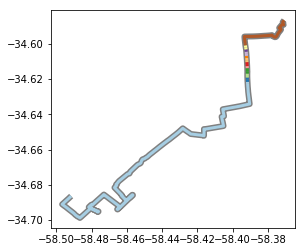

In [0]:
##### INTERNO 4001 #####
# Filtro la linea y los puntos
linea = rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'VUELTA') & (rec_teoricos.RECORRIDO == 'B')]
puntos = puntos_corte.loc[puntos_corte.INTERNO == 4001].sort_values(['RECORD_DATE'])


#Aplico el segmentado
segmentado = split_line_by_nearest_points(linea, puntos, 0.0005)

##Miro si corto bien
fig, ax = plt.subplots()
linea.plot(ax=ax, lw=6, color='gray')
segmentado.plot(ax=ax, column='index', lw=3, cmap='Paired')
#punto.plot(ax=ax, zorder=3, alpha = 0.1)

## Me quedo con los indices pares
puntos = puntos.iloc[list(range(len(puntos)))[0::2]].reset_index()
del puntos['level_0']
del puntos['index']
puntos = puntos.iloc[list(range(len(puntos)-1))].reset_index()
del puntos['index']

## Elimino la primera linea del segmentado y la última
interno_4001 = segmentado.iloc[1:len(segmentado)-1].reset_index()
del interno_4001['level_0']
del interno_4001['index']

##Concateno la informacion 
interno_4001 = pd.concat([interno_4001, puntos.loc[:,['LINEA', 'INTERNO', 'CANTIDAD', 'color', 'grosor']]], axis=1)

interno_4001 = interno_4001.iloc[list(range(1,len(interno_4001)))]

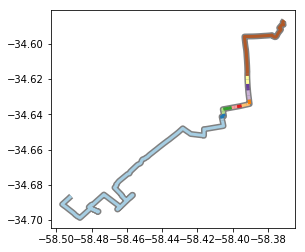

In [0]:
##### INTERNO 4032 #####
##Filtro los puntos
puntos = puntos_corte.loc[puntos_corte.INTERNO == 4032].sort_values(['RECORD_DATE'])
puntos = puntos.iloc[list(range(len(puntos)-1))].reset_index()

#Aplico el segmentado
segmentado = split_line_by_nearest_points(linea, puntos, 0.001)

##Miro si corto bien
fig, ax = plt.subplots()
linea.plot(ax=ax, lw=6, color='gray')
segmentado.plot(ax=ax, column='index', lw=3, cmap='Paired')
#punto.plot(ax=ax, zorder=3, alpha = 0.1)

## Me quedo con los indices pares
puntos = puntos.iloc[list(range(len(puntos)))[0::2]]
del puntos['level_0']
puntos = puntos.reset_index()
del puntos['level_0']
del puntos['index']

## Elimino la primera linea del segmentado y la última
interno_4032 = segmentado.iloc[2:len(segmentado)-2].reset_index()
del interno_4032['level_0']
del interno_4032['index']

##Concateno la informacion 
interno_4032 = pd.concat([interno_4032, puntos.loc[:,['LINEA', 'INTERNO', 'CANTIDAD', 'color', 'grosor']]], axis=1)



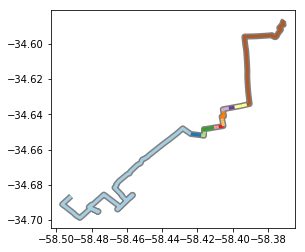

In [0]:
##### INTERNO 4049 #####
##Filtro los puntos
puntos = puntos_corte.loc[puntos_corte.INTERNO == 4049].sort_values(['RECORD_DATE'])
puntos = puntos.iloc[list(range(len(puntos)-1))].reset_index()

#Aplico el segmentado
segmentado = split_line_by_nearest_points(linea, puntos, 0.001)

##Miro si corto bien
fig, ax = plt.subplots()
linea.plot(ax=ax, lw=6, color='gray')
segmentado.plot(ax=ax, column='index', lw=3, cmap='Paired')
#punto.plot(ax=ax, zorder=3, alpha = 0.1)

## Me quedo con los indices pares
puntos = puntos.iloc[list(range(len(puntos)))[0::2]]
del puntos['level_0']
puntos = puntos.reset_index()
del puntos['level_0']
del puntos['index']

## Elimino la primera linea del segmentado y la última
interno_4049 = segmentado.iloc[2:len(segmentado)-2].reset_index()
del interno_4049['level_0']
del interno_4049['index']


##Concateno la informacion 
interno_4049 = pd.concat([interno_4049, puntos.loc[:,['LINEA', 'INTERNO', 'CANTIDAD', 'color', 'grosor']]], axis=1)

#interno_4032 = interno_4001.iloc[list(range(1,len(interno_4032)))]"""

In [0]:
######################################
######### Gráfico de Lineas ##########
######################################

m = folium.Map(location=[-34.6, -58.4], 
               zoom_start=12, 
               tiles = 'cartodbpositron')

### Línea teórica ###
# RAMAL B VUELTA
B_vuelta = folium.FeatureGroup(name='L150 B VUELTA')

## Me quedo con las coordenadas
g = [i for i in rec_teoricos.loc[(rec_teoricos.LINEA == 150) & (rec_teoricos.SENTIDO == 'VUELTA') & (rec_teoricos.RECORRIDO == 'B')]['GEOMETRY']]
x,y = g[0].coords.xy
coords = np.dstack((y,x)).tolist()

#Creo la línea
linea_sentido = folium.PolyLine(coords, weight=8, color='#7CB7FF', opacity=0.15).add_to(B_vuelta)

#Creo la flecha para indicar sentido
attr = {'fill': '#000000', 'opacity' : 0.6, 'font-size': 8}
plugins.PolyLineTextPath( linea_sentido,
                         '\u25BA',
                         repeat=True,
                         offset = 2,
                         attributes=attr).add_to(B_vuelta)
B_vuelta.add_to(m)



##Líneas
int4001 = folium.FeatureGroup(name='Interno 4001')
for name, row in interno_4001.iterrows():
    ## Me quedo con las coordenadas
    x, y = row.geometry.coords.xy
    coords = np.dstack((y,x)).tolist()

    folium.PolyLine(coords, 
                    weight = (row.CANTIDAD*row.grosor)/20, 
                    color= row.color,#'#FF0000', 
                    opacity=0.5, 
                    popup = str(row.CANTIDAD)).add_to(int4001)

int4032 = folium.FeatureGroup(name='Interno 4032')
for name, row in interno_4032.iterrows():
    ## Me quedo con las coordenadas
    x, y = row.geometry.coords.xy
    coords = np.dstack((y,x)).tolist()

    folium.PolyLine(coords, 
                    weight = (row.CANTIDAD*row.grosor)/10, 
                    color= row.color,#'#FF0000', 
                    opacity=0.5, 
                    popup = str(row.CANTIDAD)).add_to(int4032)
    

int4049 = folium.FeatureGroup(name='Interno 4049')    
for name, row in interno_4049.iterrows():
    ## Me quedo con las coordenadas
    x, y = row.geometry.coords.xy
    coords = np.dstack((y,x)).tolist()

    folium.PolyLine(coords, 
                    weight = (row.CANTIDAD*row.grosor)/15, 
                    color= row.color,#'#FF0000', 
                    opacity=0.5, 
                    popup = str(row.CANTIDAD)).add_to(int4049)
    

int4001.add_to(m)
int4032.add_to(m)
int4049.add_to(m)

### Otros mapas de fondo ###
folium.TileLayer('cartodbdark_matter').add_to(m)
folium.TileLayer('cartodbpositron').add_to(m)
folium.TileLayer('openstreetmap').add_to(m)

### Agrego un mini Mapa ###
m.add_child(plugins.MiniMap(toggle_display=True,
                           tile_layer='cartodbpositron'))
# Agrego la capa de control
folium.LayerControl().add_to(m)

m.save('Grafico_lineas.html')

m